In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
%matplotlib inline


In [27]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [28]:
len(words)

32033

In [29]:
#build the vocab of charactesr and mappings to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [30]:
#build the dataset

block_size = 3 #context length -> how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [31]:
import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])     #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [132]:
#MLP revisited
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #THe number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator = g) * (5/3) / ((n_embd*block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                          generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn(vocab_size,                        generator = g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no. of params in total

for p in parameters:
    p.requires_grad = True


11897


In [118]:
#Note the multiplicative value is simply the resultant std
(torch.randn(10000)*0.2).std()

tensor(0.1987)

In [122]:
#for tanh
kaiming_init = (5/3) / (30**0.5)
kaiming

0.3042903097250923

tensor(-0.0129) tensor(0.9988)
tensor(0.0005) tensor(1.0260)


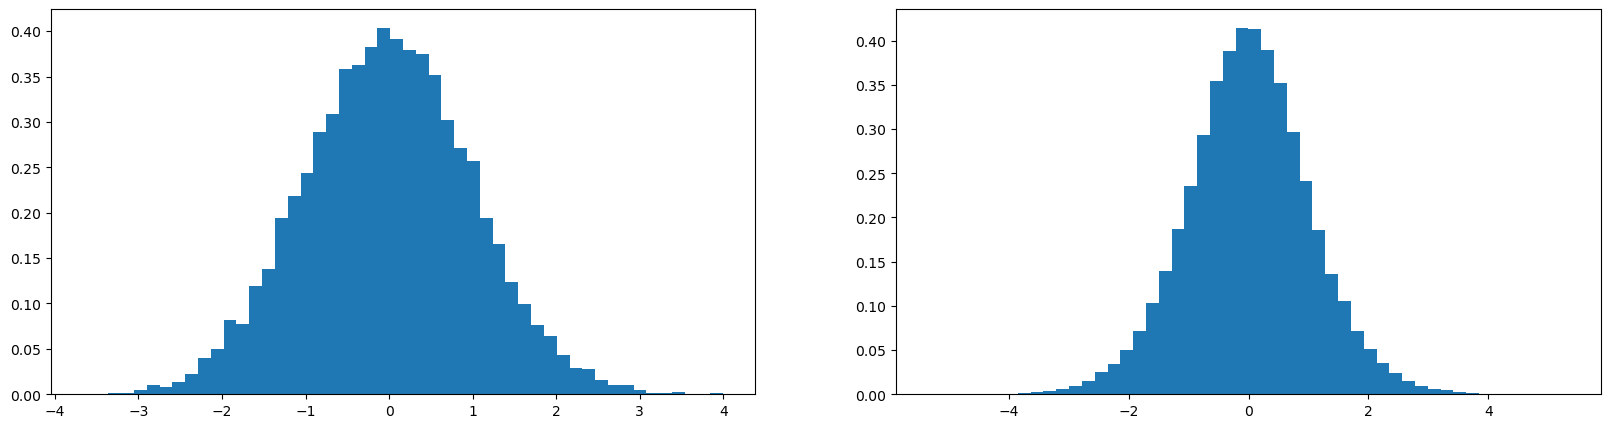

In [115]:
x = torch.randn(1000,10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [126]:
hpreact.shape

torch.Size([32, 200])

In [ ]:
hpreact.mean(0, keepdim=True)

In [138]:
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #THe number of neurons in the hidden layer of the MLP

#note if using batchnorm on a layer better to not use the bias as its wasteful and its already 
# being cancelled out by the batchnorm bias
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator = g) * (5/3) / ((n_embd*block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden,                          generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn(vocab_size,                        generator = g) * 0

#BatchNorm parameters
bngain = torch.ones((1, n_hidden)) #batchnorm gain
bnbias = torch.zeros((1, n_hidden)) #batchnorm bias
bnmean_running = torch.zeros((1, n_hidden)) #buffer mean
bnstd_running = torch.ones((1, n_hidden)) #buffer bias

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no. of params in total

for p in parameters:
    p.requires_grad = True

11897


In [139]:
#same optimisation as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    hpreact = embcat @ W1 + #b1 #hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)/hpreact.std(0,keepdim=True)) + bnbias
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print occassionally
        print(f'{i:7d}/{max_steps: 7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    
    # break


      0/ 200000:  3.3147
  10000/ 200000:  2.1942
  20000/ 200000:  2.3443
  30000/ 200000:  2.4160
  40000/ 200000:  1.9913
  50000/ 200000:  2.2978
  60000/ 200000:  2.5254
  70000/ 200000:  2.0707
  80000/ 200000:  2.3107
  90000/ 200000:  2.0663
 100000/ 200000:  1.9933
 110000/ 200000:  2.3179
 120000/ 200000:  1.9123
 130000/ 200000:  2.4505
 140000/ 200000:  2.4321
 150000/ 200000:  2.2003
 160000/ 200000:  2.0463
 170000/ 200000:  1.8839
 180000/ 200000:  1.9983
 190000/ 200000:  1.8873


'\nLots of white means very active tanh neurons on flat tail and backward \ngrad would get destroyed. Entire column white would mean dead neuron. No single \nexample activates so nothing learns. \n'

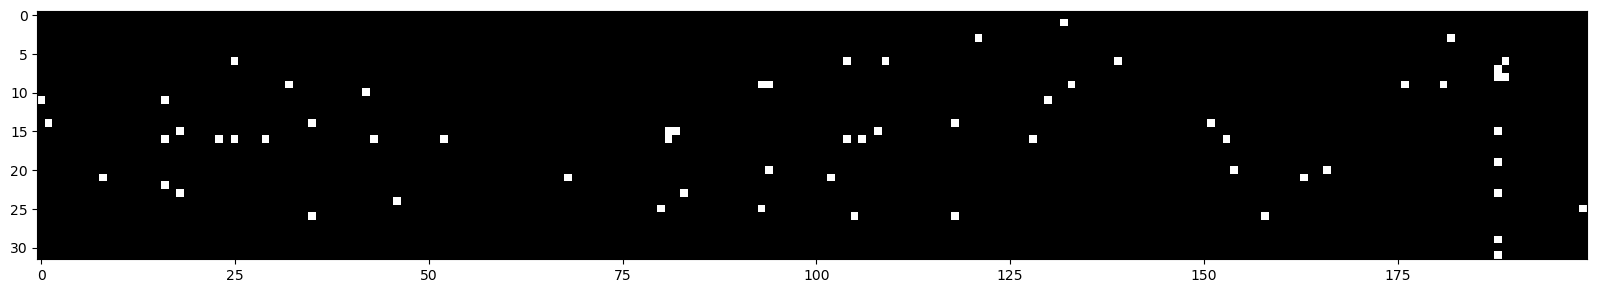

In [103]:
# plt.figure(figsize=(20,10))
# #boolean tensor -> White if true, Black if false
# plt.imshow(h.abs()> 0.99, cmap='gray', interpolation='nearest')
'''
Lots of white means very active tanh neurons on flat tail and backward 
grad would get destroyed. Entire column white would mean dead neuron. No single 
example activates so nothing learns. 
'''

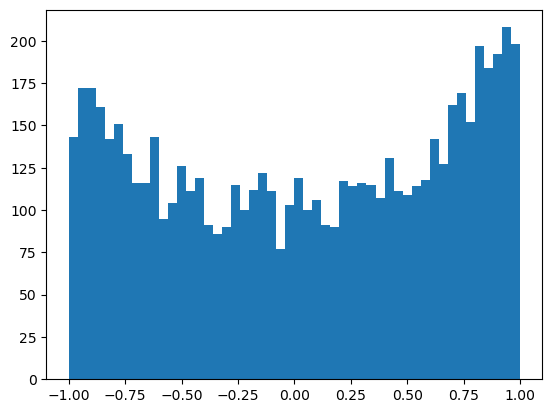

In [104]:
#Mapping the effects of the tanh function on the activations of 
#the hidden layer -> Very active
# plt.hist(h.view(-1).tolist(),50);

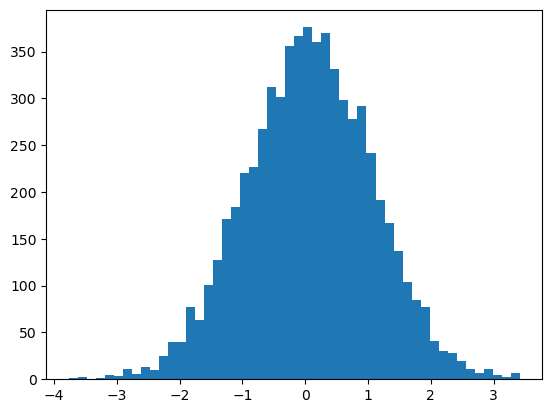

In [105]:
#Distribution of the pre activations -> very broad which is why so much squashing
# plt.hist(hpreact.view(-1).tolist(),50);

In [76]:
#4-dim example of the issue of randn weights and not uniform
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
# logits = torch.randn(4)*10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()

logits,probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [77]:
#Should be the loss we expect on the first run iter
-torch.tensor(1/27.0).log()

tensor(3.2958)

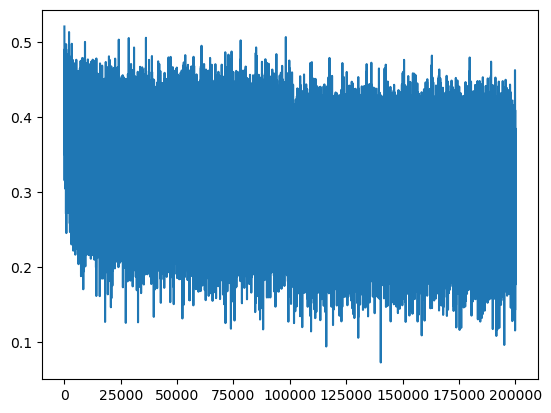

In [108]:
plt.plot(lossi)

In [140]:
#calibrate the batch norm at the end of training
with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [141]:
bnmean

tensor([[-2.3177e+00, -3.6403e-01, -1.0247e+00,  1.2613e+00,  1.7141e+00,
          1.0201e+00,  1.9386e+00, -2.2117e+00, -1.2371e-01,  1.3684e-01,
         -1.7104e+00, -1.9277e+00, -8.8309e-01,  6.2153e-01, -2.6557e-01,
         -6.3026e-01,  9.8004e-01, -2.2057e+00,  7.8219e-02,  7.9930e-01,
         -5.3765e-01,  2.7582e-01,  6.1362e-01,  1.3937e+00,  7.1977e-01,
          1.2883e+00,  1.4895e+00, -4.1137e-01,  8.4803e-01,  1.8169e+00,
         -2.1954e-01, -1.3686e+00, -7.3394e-01, -1.0650e+00, -2.0066e-01,
         -1.4059e+00, -1.8569e+00,  6.6707e-01, -8.5581e-01,  8.7046e-01,
          6.2614e-02, -4.5244e-01, -4.9263e-01,  5.2695e-01,  1.1893e+00,
          7.7381e-01,  2.7716e+00, -8.7593e-01,  1.5452e+00,  1.3719e+00,
          8.8825e-01, -2.3649e-03,  1.7612e+00,  1.3297e+00,  9.8161e-01,
         -1.8444e+00, -1.6665e-01,  6.6285e-01,  2.0306e+00, -2.8664e+00,
         -4.7368e-01,  5.8871e-01,  7.6699e-02,  6.2641e-01,  2.2088e+00,
          1.2394e+00, -3.6636e-01,  1.

In [142]:
bnmean_running

tensor([[-2.3445e+00, -3.5032e-01, -1.0127e+00,  1.2629e+00,  1.7157e+00,
          1.0086e+00,  1.9284e+00, -2.2175e+00, -1.2662e-01,  1.3021e-01,
         -1.7290e+00, -1.9392e+00, -8.8940e-01,  6.0992e-01, -2.6688e-01,
         -6.0494e-01,  9.8813e-01, -2.2140e+00,  6.0808e-02,  7.7775e-01,
         -5.3135e-01,  2.8868e-01,  6.0593e-01,  1.3920e+00,  7.1695e-01,
          1.2921e+00,  1.5023e+00, -4.1434e-01,  8.3972e-01,  1.8148e+00,
         -2.3546e-01, -1.3639e+00, -7.2678e-01, -1.0638e+00, -1.9585e-01,
         -1.4107e+00, -1.8722e+00,  6.5585e-01, -8.4153e-01,  8.7341e-01,
          4.7282e-02, -4.7717e-01, -4.9641e-01,  5.2342e-01,  1.2032e+00,
          7.9042e-01,  2.7750e+00, -8.7956e-01,  1.5351e+00,  1.3743e+00,
          8.7428e-01, -8.4311e-03,  1.7559e+00,  1.3274e+00,  9.8032e-01,
         -1.8463e+00, -1.6473e-01,  6.5882e-01,  2.0454e+00, -2.8682e+00,
         -4.9856e-01,  5.8613e-01,  6.3039e-02,  6.2299e-01,  2.2022e+00,
          1.2326e+00, -3.7523e-01,  1.

In [143]:
@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte}
    } [split]

    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concat into (N, block_size # n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)/hpreact.std(0,keepdim=True)) + bnbias
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.078073024749756
val 2.1128156185150146


In [110]:
#sample from the model 

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size #init with all ...
    while True:
        #forward pass the neural net
        emb = C[torch.tensor(context)] #(1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) #decode and print the generated word

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


In [147]:
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #THe number of neurons in the hidden layer of the MLP

#note if using batchnorm on a layer better to not use the bias as its wasteful and its already 
# being cancelled out by the batchnorm bias
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator = g) * (5/3) / ((n_embd*block_size)**0.5) #* 0.2
# b1 = torch.randn(n_hidden,                          generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01
b2 = torch.randn(vocab_size,                        generator = g) * 0

#BatchNorm parameters
bngain = torch.ones((1, n_hidden)) #batchnorm gain
bnbias = torch.zeros((1, n_hidden)) #batchnorm bias
bnmean_running = torch.zeros((1, n_hidden)) #buffer mean
bnstd_running = torch.ones((1, n_hidden)) #buffer bias

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) #no. of params in total

for p in parameters:
    p.requires_grad = True

11897


In [148]:
#--------- REWRITTEN FOR CLARITY TRAINING LOOP WITH BATCH NORM -------#
#same optimisation as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
    
    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors

    #Linear Layer
    hpreact = embcat @ W1 #+ b1 #hidden layer pre-activation
    #BatchNorm Layer
    # ----------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ----------------------------------------------------------------------
    #Non-linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print occassionally
        print(f'{i:7d}/{max_steps: 7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [149]:
#SUMMARY ----------- Pytorchify NN

In [150]:
#Let's train a deeper network 

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum 
        self.training  = True
        # params (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var (0, keepdim=True, unbiased = True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-mean)/torch.sqrt(xvar + self.eps) #normalise to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self_running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__ (self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10 #the  dimentionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) #for reproductibility

C = torch.randn ((vocab_size, n_embd),          generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].weight *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params)) #number of params in total
for p in params:
    p.requires_grad = True


46497


In [152]:
params

[tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
          -2.9644e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01],
         [-4.7125e-01,  7.8682e-01, -3.2844e-01, -4.3297e-01,  1.3729e+00,
           2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4040e-01],
         [ 9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0731e-02,
           2.4968e+00,  2.4448e+00, -6.7006e-01, -1.2199e+00,  3.0314e-01],
         [-1.0725e+00,  7.2762e-01,  5.1114e-02,  1.3095e+00, -8.0220e-01,
          -8.5042e-01, -1.8068e+00,  1.2523e+00, -1.2256e+00,  1.2165e+00],
         [-9.6478e-01, -2.3211e-01, -3.4762e-01,  3.3244e-01, -1.3263e+00,
           1.1224e+00,  5.9641e-01,  4.5846e-01,  5.4011e-02, -1.7400e+00],
         [ 1.1560e-01,  8.0319e-01,  5.4108e-01, -1.1646e+00,  1.4756e-01,
          -1.0006e+00,  3.8012e-01,  4.7328e-01, -9.1027e-01, -7.8305e-01],
         [ 1.3506e-01, -2.1161e-01, -1.0406e+00, -1.5367e+00,  9.3743e-01,
          -8.8303e-

In [153]:
# same optimisation as last time 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0],-1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb) #loss function

    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain_graph
    for p in params:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.1 #step learning rate decay
    for p in params:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # AFTER_DEBUG: would take out obviously to run full optimisation 

      0/ 200000: 3.2989


layer 1 (      Tanh)L mean -0.02 std 0.76, saturated: 21.03%
layer 3 (      Tanh)L mean +0.00 std 0.68, saturated: 8.38%
layer 5 (      Tanh)L mean -0.00 std 0.67, saturated: 7.41%
layer 7 (      Tanh)L mean -0.03 std 0.66, saturated: 5.81%
layer 9 (      Tanh)L mean -0.03 std 0.66, saturated: 6.59%


Text(0.5, 1.0, 'activation distribution')

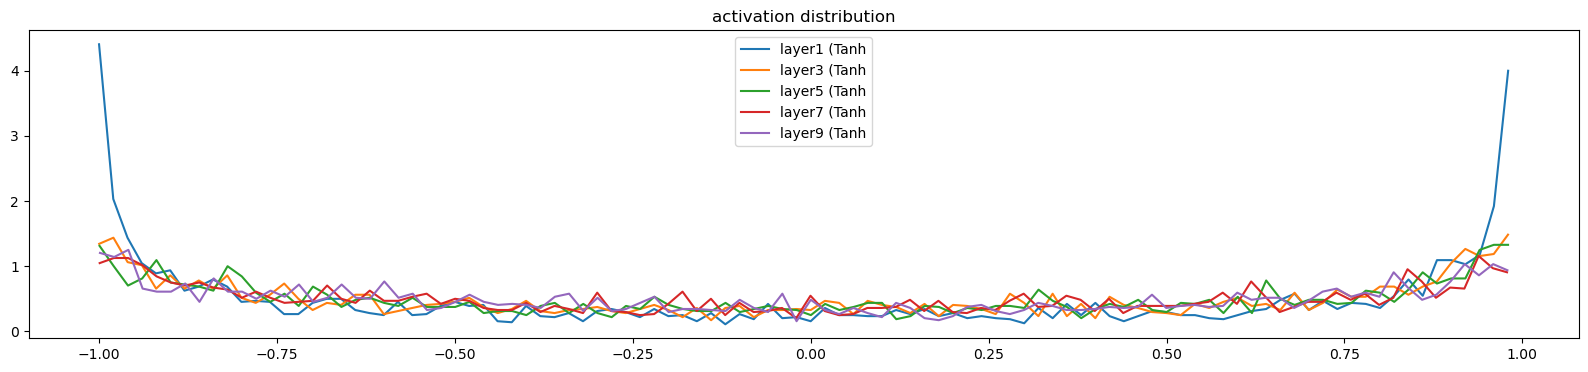

In [157]:
#visualise histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s)L mean %+.2f std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000014 std 4.186794e-04
layer 3 (      Tanh): mean -0.000008 std 3.986535e-04
layer 5 (      Tanh): mean +0.000011 std 3.723455e-04
layer 7 (      Tanh): mean +0.000001 std 3.431792e-04
layer 9 (      Tanh): mean +0.000007 std 3.068623e-04


Text(0.5, 1.0, 'gradient distribution')

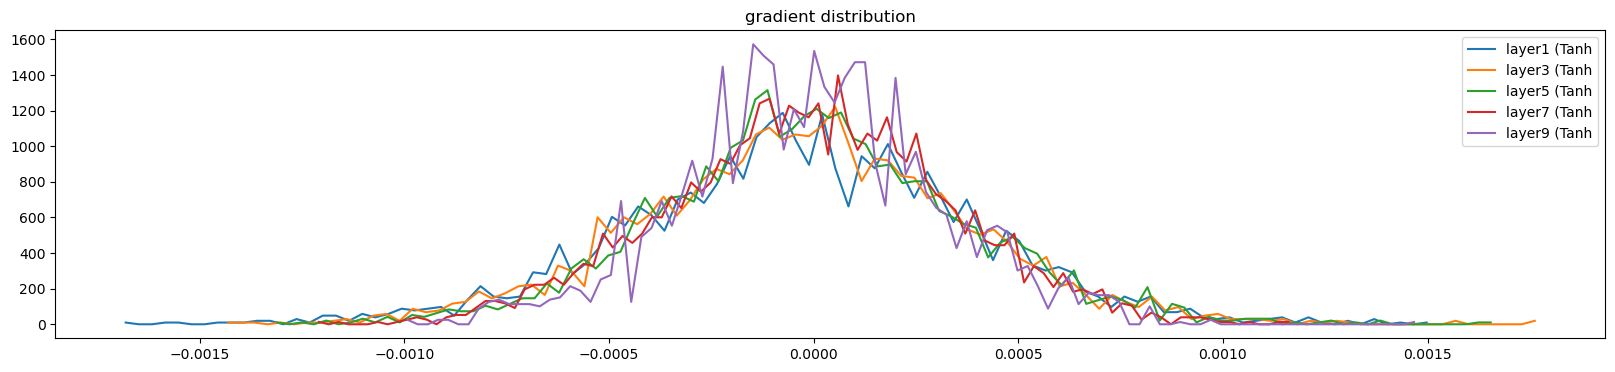

In [168]:
#visualise histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []

for i,layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000056 | std 1.562452e-03 | grad:data ratio 1.561322e-03
weight  (30, 100) | mean -0.000024 | std 1.399530e-03 | grad:data ratio 4.487636e-03
weight (100, 100) | mean +0.000003 | std 1.251627e-03 | grad:data ratio 7.534426e-03
weight (100, 100) | mean -0.000003 | std 1.056769e-03 | grad:data ratio 6.294623e-03
weight (100, 100) | mean +0.000006 | std 9.340962e-04 | grad:data ratio 5.587304e-03
weight (100, 100) | mean -0.000004 | std 8.971729e-04 | grad:data ratio 5.361252e-03
weight  (100, 27) | mean +0.000000 | std 2.598269e-02 | grad:data ratio 2.546178e+00


Text(0.5, 1.0, 'weights gradient distribution')

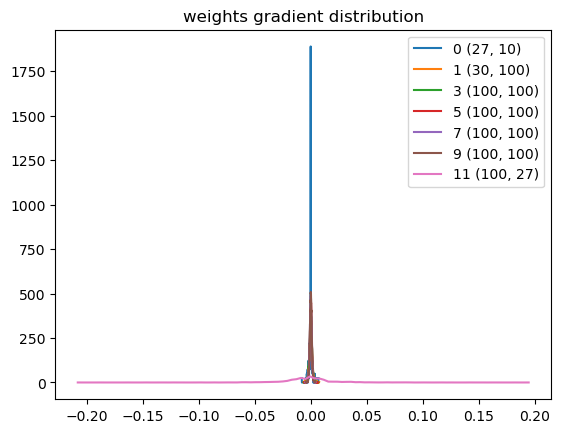

In [171]:
#visualise histogram
plt.plot(figsize=(20,4))
legends = []
for i, p in enumerate(params):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(),t.std()/p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')
    